The agent is comprised of a router using OpenAI function calling, and a set of three tools: a database lookup tool, a data analysis tool, and a code generator to create graphs.

![img](https://raw.githubusercontent.com/locchh/llm-playground/356c24bcd38ead072e9aa7e6d90dd7b2b2ff4c4b/notebooks/Evaluating_AI_Agents/images/agent.png)

The agent can lookup information from a local file, perform analysis on that information, and graph results. The example local file is a log of transactions at a local store. The agent can help the store owners understand trends and anomalies in their sales data.

### Initializing the OpenAI client

In [1]:
import json
import duckdb
import pandas as pd
from pydantic import BaseModel, Field
from IPython.display import Markdown
from helper import set_openai_key, test_openai_api, create_openai_client, print_pretty

set_openai_key()

test_openai_api()

client = create_openai_client()

MODEL = "gpt-4o-mini"

API key set successfully.
Hello! How can I assist you today?


In [2]:
# define the path to the transactional data
TRANSACTION_DATA_FILE_PATH = 'data/Store_Sales_Price_Elasticity_Promotions_Data.parquet'

### Defining the tools

Let's start by creating the three tools the agent will be able to use.

#### Tool 1: Database Lookup

This first tool reads from a local parquet file that contains the transaction data.

This database lookup tool works using three steps.

![tool1](https://raw.githubusercontent.com/locchh/llm-playground/356c24bcd38ead072e9aa7e6d90dd7b2b2ff4c4b/notebooks/Evaluating_AI_Agents/images/tool1.png)

1. First, it creates the SQL table from a local file, if not already done.
2. Second, it translates the original prompt into an sql query (using an LLM call).
3. Finally, it runs that query against the database.

In [3]:
# prompt template for step 2 of tool 1
SQL_GENERATION_PROMPT = """
Generate an SQL query based on a prompt. Do not reply with anything besides the SQL query.
The prompt is: {prompt}

The available columns are: {columns}
The table name is: {table_name}
"""


# code for step 2 of tool 1
def generate_sql_query(prompt: str, columns: list, table_name: str) -> str:
    """Generate an SQL query based on a prompt"""
    formatted_prompt = SQL_GENERATION_PROMPT.format(prompt=prompt, 
                                                    columns=columns, 
                                                    table_name=table_name)

    response = client.chat.completions.create(
        model=MODEL,
        messages=[{"role": "user", "content": formatted_prompt}],
    )
    
    return response.choices[0].message.content


In [4]:
# code for tool 1
def lookup_sales_data(prompt: str) -> str:
    """Implementation of sales data lookup from parquet file using SQL"""
    try:

        # define the table name
        table_name = "sales"
        
        # step 1: read the parquet file into a DuckDB table
        df = pd.read_parquet(TRANSACTION_DATA_FILE_PATH)

        # creates a DuckDB database table from a Pandas DataFrame (df) if it doesn't already exist.
        duckdb.sql(f"CREATE TABLE IF NOT EXISTS {table_name} AS SELECT * FROM df")

        # step 2: generate the SQL code
        sql_query = generate_sql_query(prompt, df.columns, table_name)
        # clean the response to make sure it only includes the SQL code
        sql_query = sql_query.strip()
        sql_query = sql_query.replace("```sql", "").replace("```", "")
        
        # step 3: execute the SQL query
        result = duckdb.sql(sql_query).df()
        
        return result.to_string()
    except Exception as e:
        return f"Error accessing data: {str(e)}"


In [5]:
example_data = lookup_sales_data("Show me all the sales for store 1320 on November 1st, 2021")
print(example_data)

    Store_Number  SKU_Coded  Product_Class_Code  Sold_Date  Qty_Sold  Total_Sale_Value  On_Promo
0           1320    6173050               22875 2021-11-01         1          4.990000         0
1           1320    6174250               22875 2021-11-01         1          0.890000         0
2           1320    6176200               22975 2021-11-01         2         99.980003         0
3           1320    6176800               22800 2021-11-01         1         14.970000         0
4           1320    6177250               22975 2021-11-01         1          6.890000         0
5           1320    6177300               22800 2021-11-01         1          9.990000         0
6           1320    6177350               22800 2021-11-01         2         16.980000         0
7           1320    6177700               22875 2021-11-01         1          3.190000         0
8           1320    6178000               22875 2021-11-01         2          6.380000         0
9           1320    6178250   

#### Tool 2: Data Analysis

The second tool can analyze the returned data and display conclusions to users.

![tool2](https://raw.githubusercontent.com/locchh/llm-playground/356c24bcd38ead072e9aa7e6d90dd7b2b2ff4c4b/notebooks/Evaluating_AI_Agents/images/tool2.png)


In [6]:
# Construct prompt based on analysis type and data subset
DATA_ANALYSIS_PROMPT = """
Analyze the following data: {data}
Your job is to answer the following question: {prompt}
"""

In [7]:
# code for tool 2
def analyze_sales_data(prompt: str, data: str) -> str:
    """Implementation of AI-powered sales data analysis"""
    formatted_prompt = DATA_ANALYSIS_PROMPT.format(data=data, prompt=prompt)

    response = client.chat.completions.create(
        model=MODEL,
        messages=[{"role": "user", "content": formatted_prompt}],
    )
    
    analysis = response.choices[0].message.content
    return analysis if analysis else "No analysis could be generated"

In [8]:
print(analyze_sales_data(prompt="what trends do you see in this data", 
                         data=example_data))

Analyzing the provided sales data from a single store on a specific date, we can deduce several trends and insights based on the variables listed:

### 1. **Sales Distribution by Product Class:**
   - The data consists of multiple product classes identified by the `Product_Class_Code` column (e.g., 22800, 22875, 22975, etc.).
   - It appears that certain classes (like 24400 and 22800) have multiple transactions, indicating they might be popular products in the store.

### 2. **Quantity Sold:**
   - The `Qty_Sold` column indicates that several products were sold in single units, but there are instances where higher quantities are sold:
     - For instance, products with SKU `6183750` and `6184100` in class `22850` and `22975` respectively were sold in quantities of 3, suggesting these may be well-received items or bundled offers.
   - The maximum quantity sold in the dataset is 5 for SKU `6190050`, indicating a potential bulk order or high demand.

### 3. **Total Sale Value Analysis:**


#### Tool 3: Data Visualization

The third tool generates python code to create the requested graphs from the returned data of the first tool. It consists of two steps: 

![tool3](https://raw.githubusercontent.com/locchh/llm-playground/356c24bcd38ead072e9aa7e6d90dd7b2b2ff4c4b/notebooks/Evaluating_AI_Agents/images/tool3.png)

1. First, it creates the chart configuration: chart type, title, data, lables for x-axis and y-axis (using an LLM call).
2. Second, it generates the python code based on the chart configuration of the first step (using an LLM call).

In [9]:
# prompt template for step 1 of tool 3
CHART_CONFIGURATION_PROMPT = """
Generate a chart configuration based on this data: {data}
The goal is to show: {visualization_goal}
"""

In [10]:
# class defining the response format of step 1 of tool 3
class VisualizationConfig(BaseModel):
    chart_type: str = Field(..., description="Type of chart to generate")
    x_axis: str = Field(..., description="Name of the x-axis column")
    y_axis: str = Field(..., description="Name of the y-axis column")
    title: str = Field(..., description="Title of the chart")

In [12]:
# code for step 1 of tool 3
def extract_chart_config(data: str, visualization_goal: str) -> dict:
    """Generate chart visualization configuration
    
    Args:
        data: String containing the data to visualize
        visualization_goal: Description of what the visualization should show
        
    Returns:
        Dictionary containing line chart configuration
    """
    formatted_prompt = CHART_CONFIGURATION_PROMPT.format(data=data,
                                                         visualization_goal=visualization_goal)
    
    response = client.beta.chat.completions.parse(
        model=MODEL,
        messages=[{"role": "user", "content": formatted_prompt}],
        response_format=VisualizationConfig,
    )
    
    try:
        # Extract axis and title info from response
        content = response.choices[0].message.content
        
        # Return structured chart config
        return {
            "chart_type": content.chart_type,
            "x_axis": content.x_axis,
            "y_axis": content.y_axis,
            "title": content.title,
            "data": data
        }
    except Exception:
        return {
            "chart_type": "line", 
            "x_axis": "date",
            "y_axis": "value",
            "title": visualization_goal,
            "data": data
        }

In [13]:
# prompt template for step 2 of tool 3
CREATE_CHART_PROMPT = """
Write python code to create a chart based on the following configuration.
Only return the code, no other text.
config: {config}
"""


In [14]:
# code for step 2 of tool 3
def create_chart(config: dict) -> str:
    """Create a chart based on the configuration"""
    formatted_prompt = CREATE_CHART_PROMPT.format(config=config)
    
    response = client.chat.completions.create(
        model=MODEL,
        messages=[{"role": "user", "content": formatted_prompt}],
    )
    
    code = response.choices[0].message.content
    code = code.replace("```python", "").replace("```", "")
    code = code.strip()
    
    return code

In [15]:
# code for tool 3
def generate_visualization(data: str, visualization_goal: str) -> str:
    """Generate a visualization based on the data and goal"""
    config = extract_chart_config(data, visualization_goal)
    code = create_chart(config)
    return code

In [20]:
code = generate_visualization(example_data, 
                              "A bar chart of sales by product SKU. Put the product SKU on the x-axis and the sales on the y-axis.")
print(code)

import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO

# Configuration
config = {
    'chart_type': 'line',
    'x_axis': 'Sold_Date',
    'y_axis': 'Total_Sale_Value',
    'title': 'A bar chart of sales by product SKU. Put the product SKU on the x-axis and the sales on the y-axis.',
    'data': '    Store_Number  SKU_Coded  Product_Class_Code  Sold_Date  Qty_Sold  Total_Sale_Value  On_Promo\n0           1320    6173050               22875 2021-11-01         1          4.990000         0\n1           1320    6174250               22875 2021-11-01         1          0.890000         0\n2           1320    6176200               22975 2021-11-01         2         99.980003         0\n3           1320    6176800               22800 2021-11-01         1         14.970000         0\n4           1320    6177250               22975 2021-11-01         1          6.890000         0\n5           1320    6177300               22800 2021-11-01         1          9.990000      

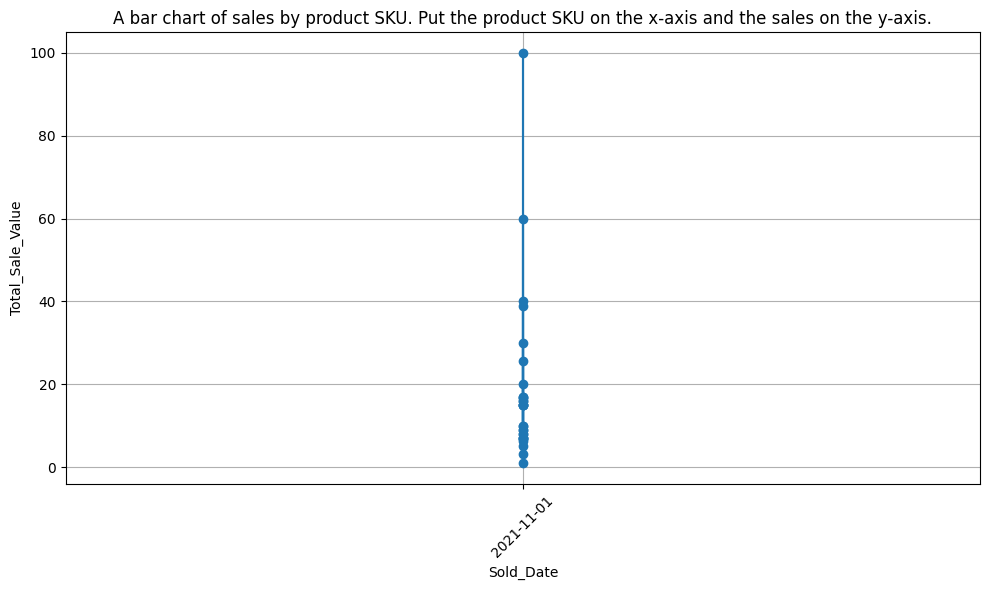

In [21]:
exec(code)

### Defining the Router

Now that all of the tools are defined, you can create the router. The router will take the original user input, and is responsible for calling any tools. After each tool call is completed, the agent will return to router to determine whether another tool should be called.


#### Tool Schema



Let's define the tools in a way that can be understood by our OpenAI model. OpenAI understands a specific JSON format:


In [22]:
# Define tools/functions that can be called by the model
tools = [
    {
        "type": "function",
        "function": {
            "name": "lookup_sales_data",
            "description": "Look up data from Store Sales Price Elasticity Promotions dataset",
            "parameters": {
                "type": "object",
                "properties": {
                    "prompt": {"type": "string", "description": "The unchanged prompt that the user provided."}
                },
                "required": ["prompt"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "analyze_sales_data", 
            "description": "Analyze sales data to extract insights",
            "parameters": {
                "type": "object",
                "properties": {
                    "data": {"type": "string", "description": "The lookup_sales_data tool's output."},
                    "prompt": {"type": "string", "description": "The unchanged prompt that the user provided."}
                },
                "required": ["data", "prompt"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "generate_visualization",
            "description": "Generate Python code to create data visualizations",
            "parameters": {
                "type": "object", 
                "properties": {
                    "data": {"type": "string", "description": "The lookup_sales_data tool's output."},
                    "visualization_goal": {"type": "string", "description": "The goal of the visualization."}
                },
                "required": ["data", "visualization_goal"]
            }
        }
    }
]

# Dictionary mapping function names to their implementations
tool_implementations = {
    "lookup_sales_data": lookup_sales_data,
    "analyze_sales_data": analyze_sales_data, 
    "generate_visualization": generate_visualization
}


#### Router Logic

The router is composed of a main loop method, and a method to handle the tool calls that you get back from the model.

![router](https://raw.githubusercontent.com/locchh/llm-playground/356c24bcd38ead072e9aa7e6d90dd7b2b2ff4c4b/notebooks/Evaluating_AI_Agents/images/router.png)

The following two cells define the function `handle_tool_calls` and the variable `SYSTEM_PROMPT`, which will be used by the function `run_agent` defining the router logic.

In [23]:
# code for executing the tools returned in the model's response
def handle_tool_calls(tool_calls, messages):
    
    for tool_call in tool_calls:   
        function = tool_implementations[tool_call.function.name]
        function_args = json.loads(tool_call.function.arguments)
        result = function(**function_args)
        messages.append({"role": "tool", "content": result, "tool_call_id": tool_call.id})
        
    return messages

In [24]:
SYSTEM_PROMPT = """
You are a helpful assistant that can answer questions about the Store Sales Price Elasticity Promotions dataset.
"""

In [26]:
def run_agent(messages):
    print("Running agent with messages:", messages)

    if isinstance(messages, str):
        messages = [{"role": "user", "content": messages}]
        
    # Check and add system prompt if needed
    if not any(
            isinstance(message, dict) and message.get("role") == "system" for message in messages
        ):
            system_prompt = {"role": "system", "content": SYSTEM_PROMPT}
            messages.append(system_prompt)

    while True:
        print("Making router call to OpenAI")
        response = client.chat.completions.create(
            model=MODEL,
            messages=messages,
            tools=tools,
        )
        messages.append(response.choices[0].message)
        tool_calls = response.choices[0].message.tool_calls
        print("Received response with tool calls:", bool(tool_calls))

        # if the model decides to call function(s), call handle_tool_calls
        if tool_calls:
            print("Processing tool calls")
            messages = handle_tool_calls(tool_calls, messages)
        else:
            print("No tool calls, returning final response")
            return response.choices[0].message.content


In [27]:
result = run_agent('Show me the code for graph of sales by store in Nov 2021, and tell me what trends you see.')

Running agent with messages: Show me the code for graph of sales by store in Nov 2021, and tell me what trends you see.
Making router call to OpenAI
Received response with tool calls: True
Processing tool calls
Making router call to OpenAI
Received response with tool calls: True
Processing tool calls
Making router call to OpenAI
Received response with tool calls: True
Processing tool calls
Making router call to OpenAI
Received response with tool calls: False
No tool calls, returning final response


In [28]:
print(result)

Here is the Python code for generating a bar graph that shows total sales by store for November 2021:

```python
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO

data = """Store_Number  Total_Quantity_Sold  Total_Sales_Value
0           3080               1454.0       18044.450005
1           4840               1612.0       19127.169971
2           2090               1080.0       11617.179888
3           4070                932.0        9161.409921
4           2640               1005.0       10891.639931
5            880               1525.0       17753.769956
6           1320               1701.0       19553.789981
7           1540               1801.0       21207.689942
8           4730                819.0       10571.779962
9           1980                893.0        9084.959929
10          2750               1462.0       16310.409961
11          2420               1370.0       15234.709888
12          3410               1345.0       15982.159946
13    

In [29]:
# you can also print a formatted version of the result
Markdown(result)

Here is the Python code for generating a bar graph that shows total sales by store for November 2021:

```python
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO

data = """Store_Number  Total_Quantity_Sold  Total_Sales_Value
0           3080               1454.0       18044.450005
1           4840               1612.0       19127.169971
2           2090               1080.0       11617.179888
3           4070                932.0        9161.409921
4           2640               1005.0       10891.639931
5            880               1525.0       17753.769956
6           1320               1701.0       19553.789981
7           1540               1801.0       21207.689942
8           4730                819.0       10571.779962
9           1980                893.0        9084.959929
10          2750               1462.0       16310.409961
11          2420               1370.0       15234.709888
12          3410               1345.0       15982.159946
13          3300               1859.0       23730.719905
14          1650               1770.0       23186.909958
15          4180                913.0       10213.819920
16           550                764.0        9554.049975
17          1100               1712.0       19298.679917
18          3190               1003.0       11934.999961
19           990               1280.0       15101.459945
20          2970               2312.0       31000.569969
21          2530                890.0       11139.740003
22          4400                225.0        4390.689987
23          3740                949.0       10719.049952
24          2310               1594.0       16611.539945
25          2200               1513.0       16854.439921
26          1870               1648.0       17091.849894
27          3630               1311.0       14202.299958
28           660               1208.0       13041.239901
29           770                973.0        9181.769959
30           330               1105.0       12569.599911
31          1210               1821.0       21021.669984
32          1760               1207.0       14598.209948"""

df = pd.read_csv(StringIO(data), sep="\s+")
plt.figure(figsize=(10, 6))
plt.bar(df['Store_Number'], df['Total_Sales_Value'])
plt.title('Total Sales by Store for November 2021')
plt.xlabel('Store Number')
plt.ylabel('Total Sales Value ($)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
```

### Observations from the Data:

- **Top Performers**: Store 2970 has the highest total sales value ($31,000), followed by Store 3300 and Store 1650, indicating these stores either have higher foot traffic or carry more popular products.
- **Low Performers**: Store 4400 has the lowest sales at only $4,390, which might be a concern that requires investigation, such as examining product availability or store location effectiveness.
- **Sales Consistency**: There appears to be a wide range in sales performance, suggesting that specific stores might need strategic evaluations to identify what factors contribute to their performance.
- **Correlation Between Quantity and Sales Value**: Stores with higher quantities sold generally show higher sales values, but there could be variations in average sales price per unit leading to differing sales values despite similar quantities.

These insights can help inform operational decisions, marketing strategies, and inventory management for the coming months.